# Construction Safety Equipment Detection

In [ ]:
from google.colab import drive
import shutil
from pathlib import Path

drive.mount('/content/drive')


# Create project folder in Google Drive
drive_project_dir = Path('/content/drive/MyDrive/PPE_Detection_Project')
drive_project_dir.mkdir(exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check GPU availability
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Set up environment

In [ ]:
# Install required libraries
!pip install ultralytics roboflow supervision -q


In [ ]:
# Import essential libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from IPython.display import display, Image
import shutil

# For YOLO
from ultralytics import YOLO
import supervision as sv

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

## Dataset Download - ROBOFLOW

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="oEAtdjAwr0AO472Bi0em")
project = rf.workspace("sdp-lfigk").project("ppe-detection-ozhfb")
version = project.version(14)
dataset = version.download("yolov8")

dataset_path = dataset.location


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PPE-DETECTION-14 in yolov8:: 100%|██████████| 4240/4240 [00:00<00:00, 8402.79it/s]


## Dataset Exploration & Visualization

In [ ]:
# Dataset Structure Verification
import yaml

# Read the data.yaml file
data_yaml_path = f"{dataset.location}/data.yaml"

with open(data_yaml_path, 'r') as file:
    data_config = yaml.safe_load(file)

print("\nDataset Configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")
print(f"\nClass Index Mapping:")
for idx, name in enumerate(data_config['names']):
    print(f"      {idx}: {name}")

# Count images in each split
def count_images(path):
    img_path = Path(path)
    if not img_path.exists():
        return 0
    jpg_count = len(list(img_path.glob('*.jpg')))
    png_count = len(list(img_path.glob('*.png')))
    jpeg_count = len(list(img_path.glob('*.jpeg')))
    return jpg_count + png_count + jpeg_count

train_count = count_images(f"{dataset.location}/train/images")
val_count = count_images(f"{dataset.location}/valid/images")
test_count = count_images(f"{dataset.location}/test/images")

total_images = train_count + val_count + test_count

print(f"\nImage Distribution:")
print(f"Training:{train_count:4d} images ({train_count/total_images*100:.1f}%)")
print(f"Validation:{val_count:4d} images ({val_count/total_images*100:.1f}%)")
print(f"Test:{test_count:4d} images ({test_count/total_images*100:.1f}%)")
print(f"Total:{total_images:4d} images")



Dataset Configuration:
Number of classes: 6
Class names: ['Gloves', 'Hard_hat', 'Mask', 'Person', 'Safety_boots', 'Vest']

Class Index Mapping:
      0: Gloves
      1: Hard_hat
      2: Mask
      3: Person
      4: Safety_boots
      5: Vest

Image Distribution:
Training:1476 images (69.8%)
Validation: 425 images (20.1%)
Test: 213 images (10.1%)
Total:2114 images


In [ ]:
# Analyze class distribution

def analyze_labels(label_dir, class_names):
    label_path = Path(label_dir)
    label_files = list(label_path.glob('*.txt'))

    class_counts = {i: 0 for i in range(len(class_names))}
    total_boxes = 0

    for label_file in label_files:
        if label_file.stat().st_size > 0:  # Check if file is not empty
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:  # Valid YOLO format
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
                        total_boxes += 1

    return class_counts, total_boxes

train_class_counts, train_total = analyze_labels(
    f"{dataset.location}/train/labels",
    data_config['names']
)

print(f"\nTraining Set Class Distribution:")
print(f"{'ID':<4} {'Class Name':<15} {'Count':>8} {'Percentage':>12}")

for class_id, count in train_class_counts.items():
    class_name = data_config['names'][class_id]
    percentage = (count/train_total)*100 if train_total > 0 else 0
    print(f"   {class_id:<4} {class_name:<15} {count:>8} {percentage:>11.1f}%")


print(f"\nTotal annotations: {train_total}")

# Highlight primary focus classes Helmet & Vest)
for focus_class in ['helmet', 'vest']:
    if focus_class in data_config['names']:
        idx = data_config['names'].index(focus_class)
        count = train_class_counts[idx]
        percentage = (count/train_total)*100 if train_total > 0 else 0
        print(f"{focus_class.upper()}: {count} instances ({percentage:.1f}%)")

#Dataset structure verified successfully

# Save for later use
dataset_info = {
    'path': dataset.location,
    'yaml_path': data_yaml_path,
    'classes': data_config['names'],
    'nc': data_config['nc'],
    'train_count': train_count,
    'val_count': val_count,
    'test_count': test_count,
    'class_distribution': train_class_counts
}


Training Set Class Distribution:
ID   Class Name         Count   Percentage
   0    Gloves              1386        21.2%
   1    Hard_hat             921        14.1%
   2    Mask                 834        12.7%
   3    Person               947        14.5%
   4    Safety_boots        1363        20.8%
   5    Vest                1098        16.8%

Total annotations: 6549


In [ ]:
# Create all necessary directories
project_dir = Path('/content/ppe_detection_project')
project_dir.mkdir(exist_ok=True)

# Create subdirectories
subdirs = ['models', 'results', 'visualizations', 'reports']
for subdir in subdirs:
    (project_dir / subdir).mkdir(exist_ok=True)
    print(f"   ✓ Created: {project_dir / subdir}")


   ✓ Created: /content/ppe_detection_project/models
   ✓ Created: /content/ppe_detection_project/results
   ✓ Created: /content/ppe_detection_project/visualizations
   ✓ Created: /content/ppe_detection_project/reports


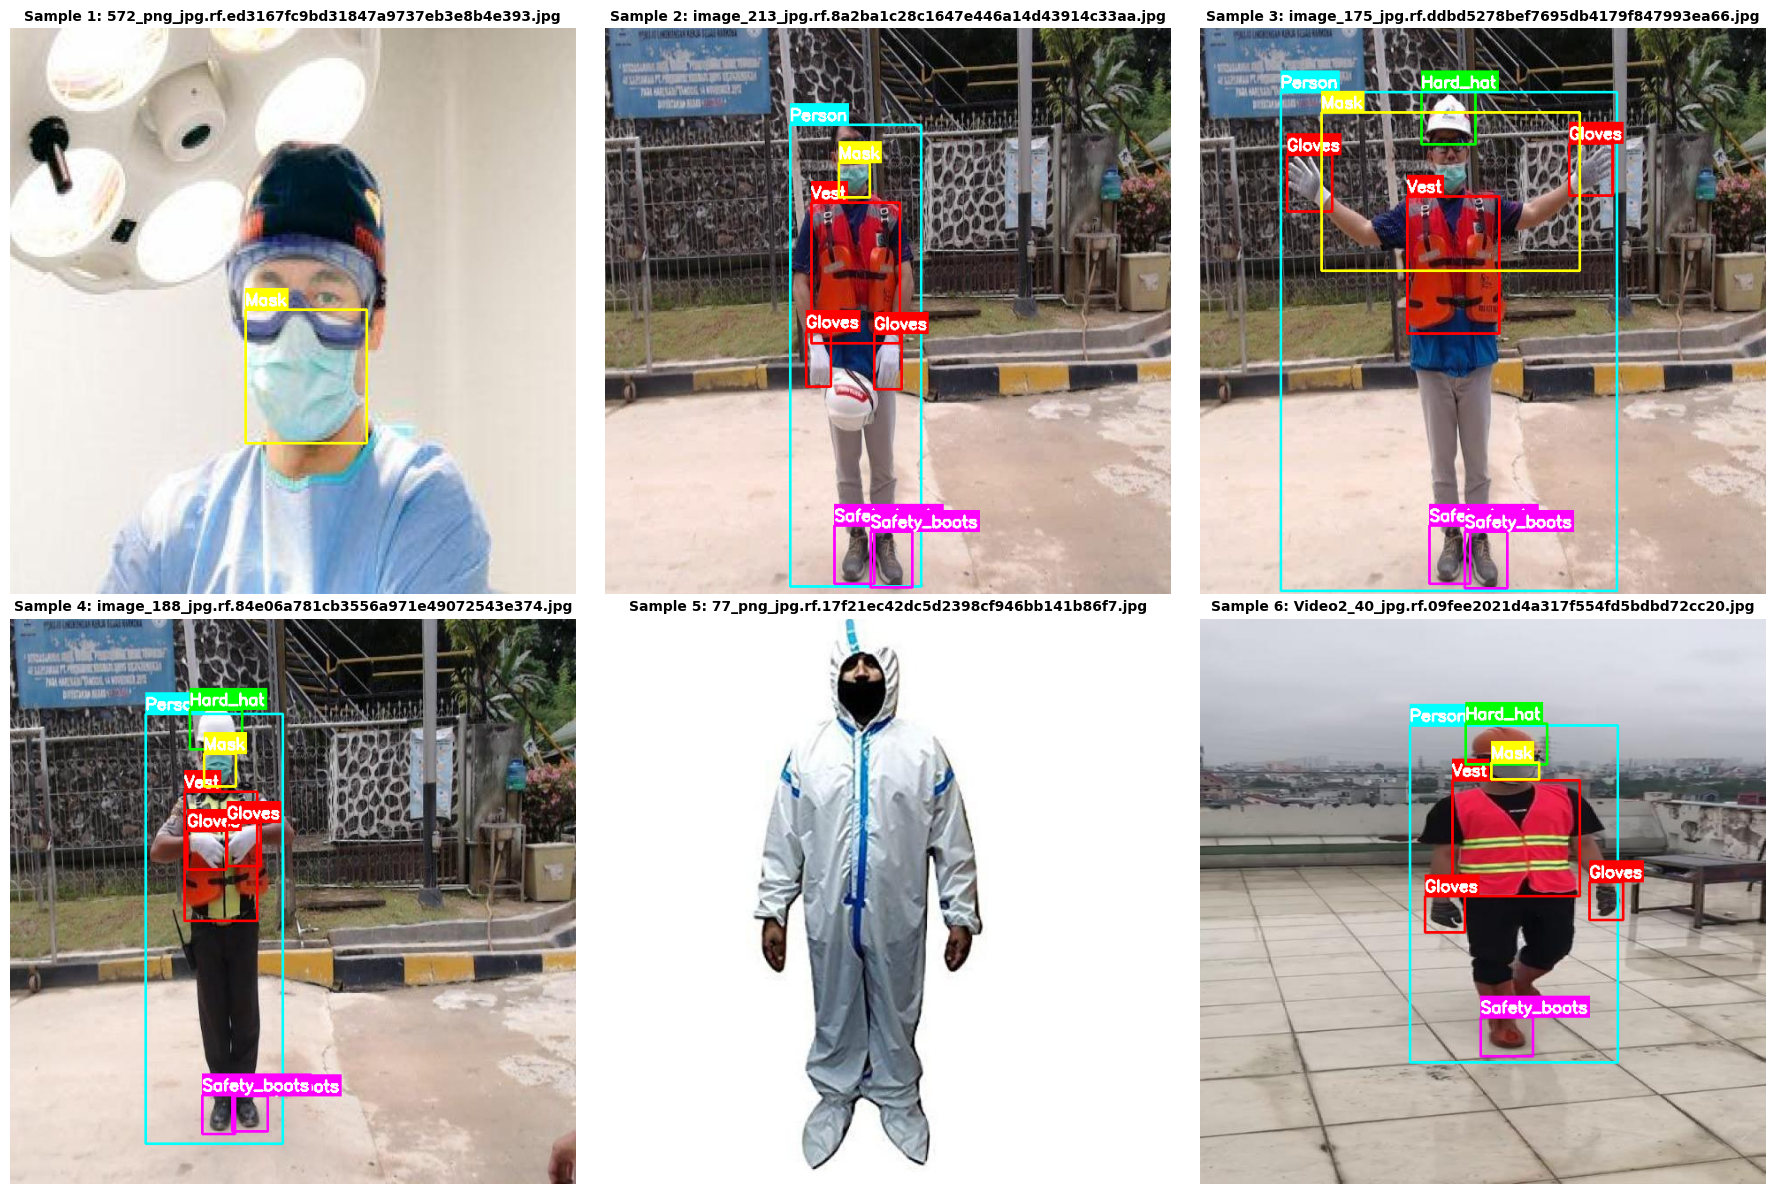

In [ ]:
#Visualizing Sample Images with Annotations

def plot_yolo_image(image_path, label_path, class_names, class_colors=None):
    # Read image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Define colors for each class if not provided
    if class_colors is None:
        np.random.seed(42)
        class_colors = {}
        for i, name in enumerate(class_names):
            class_colors[i] = tuple(np.random.randint(0, 255, 3).tolist())

    # Read YOLO labels
    if Path(label_path).exists() and Path(label_path).stat().st_size > 0:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])

                    # Convert YOLO format to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    # Draw bounding box
                    color = class_colors.get(class_id, (255, 0, 0))
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                    # Add label
                    label = class_names[class_id]
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(image, (x1, y1 - label_size[1] - 10),
                                (x1 + label_size[0], y1), color, -1)
                    cv2.putText(image, label, (x1, y1 - 5),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return image

# Define consistent colors for our classes
class_colors = {
    0: (255, 0, 0),      # boot - Red
    1: (0, 255, 0),      # gloves - Green
    2: (255, 255, 0),    # helmet - Yellow
    3: (0, 255, 255),    # human - Cyan
    4: (255, 0, 255),    # vest - Magenta
}

# Get random sample images
train_images_dir = Path(f"{dataset.location}/train/images")
train_labels_dir = Path(f"{dataset.location}/train/labels")

image_files = list(train_images_dir.glob('*.jpg')) + list(train_images_dir.glob('*.png'))

# Select random samples
num_samples = 6
sample_images = random.sample(image_files, min(num_samples, len(image_files)))

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    # Get corresponding label file
    label_path = train_labels_dir / (img_path.stem + '.txt')

    # Plot image with annotations
    annotated_img = plot_yolo_image(img_path, label_path, data_config['names'], class_colors)

    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f"Sample {idx+1}: {img_path.name}", fontsize=10, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/ppe_detection_project/visualizations/sample_annotations.png',
            dpi=150, bbox_inches='tight')
plt.show()


## Class Distribution Visualization

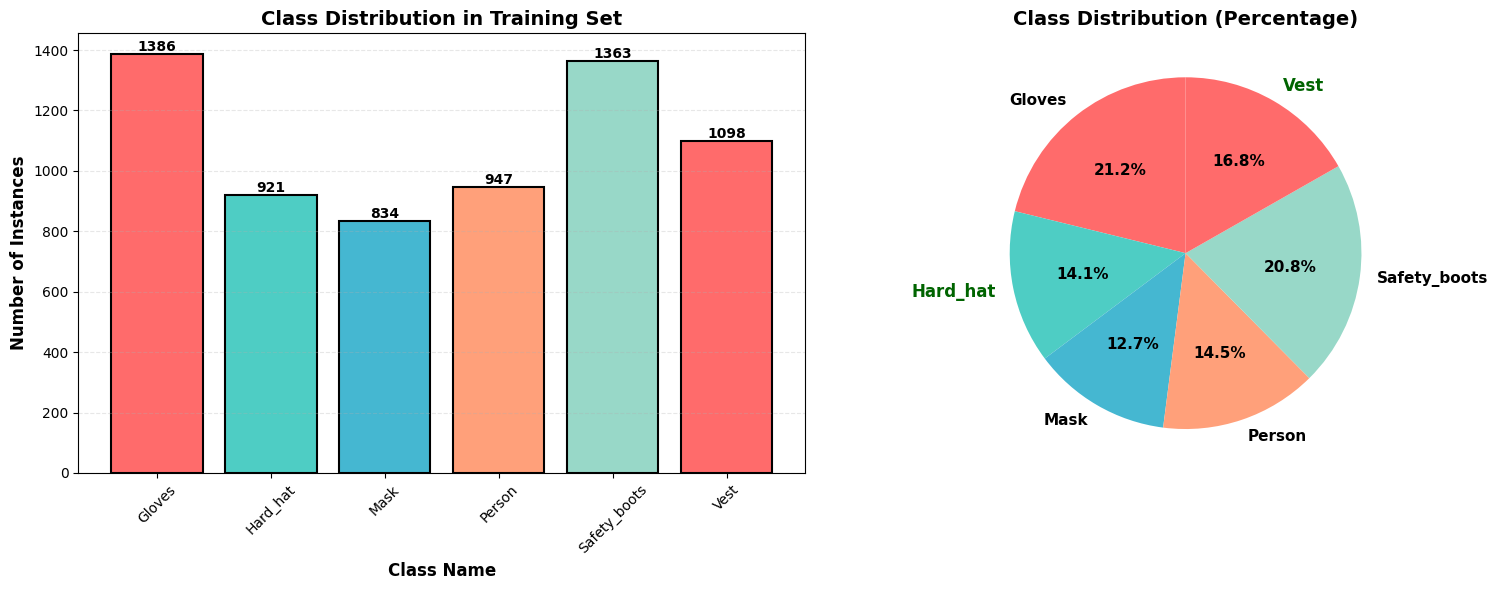


Summary Statistics:
Total training images: 1476
Total annotations: 6549
Average annotations per image: 4.44

Focus Classes Analysis (Helmet & Vest):
   HELMET: 921 instances (14.06% of all annotations)
   VEST:   1098 instances (16.77% of all annotations)

Combined Helmet + Vest: 2019 instances (30.83%)

Dataset Quality Metrics:
Images with annotations: ~1476
Average objects per image: 4.44
Classes: 6
Train/Val/Test split: 1476/425/213


In [ ]:
#Class Distribution Visualizations

# Ensure visualizations directory exists
viz_dir = Path('/content/ppe_detection_project/visualizations')
viz_dir.mkdir(parents=True, exist_ok=True)

# Prepare data for plotting
class_names = [data_config['names'][i] for i in sorted(train_class_counts.keys())]
class_counts_list = [train_class_counts[i] for i in sorted(train_class_counts.keys())]

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars = ax1.bar(class_names, class_counts_list, color=colors_bar, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Class Name', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
ax1.set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Pie chart
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
wedges, texts, autotexts = ax2.pie(class_counts_list, labels=class_names, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

# Highlight helmet and vest (check actual class names in your dataset)
for i, text in enumerate(texts):
    # Adjust these names to match your actual class names
    if class_names[i].lower() in ['helmet', 'hard_hat', 'hardhat', 'vest', 'safety_vest']:
        text.set_fontweight('bold')
        text.set_fontsize(12)
        text.set_color('darkgreen')

plt.tight_layout()
plt.savefig(str(viz_dir / 'class_distribution.png'),
            dpi=150, bbox_inches='tight')
plt.show()


# Summary statistics
print(f"\nSummary Statistics:")
print(f"Total training images: {train_count}")
print(f"Total annotations: {train_total}")
print(f"Average annotations per image: {train_total/train_count:.2f}")

# Focus classes analysis
print(f"\nFocus Classes Analysis (Helmet & Vest):")

# Find helmet class (might be named differently)
helmet_names = ['helmet', 'hard_hat', 'hardhat', 'Hard_hat']
vest_names = ['vest', 'safety_vest', 'Vest', 'safety-vest']

helmet_idx = None
vest_idx = None

# Find helmet
for h_name in helmet_names:
    if h_name in data_config['names']:
        helmet_idx = data_config['names'].index(h_name)
        break

# Find vest
for v_name in vest_names:
    if v_name in data_config['names']:
        vest_idx = data_config['names'].index(v_name)
        break

if helmet_idx is not None:
    helmet_count = train_class_counts[helmet_idx]
    helmet_pct = (helmet_count / train_total) * 100
    print(f"   HELMET: {helmet_count} instances ({helmet_pct:.2f}% of all annotations)")
else:
    print(f"   HELMET: Not found in dataset")

if vest_idx is not None:
    vest_count = train_class_counts[vest_idx]
    vest_pct = (vest_count / train_total) * 100
    print(f"   VEST:   {vest_count} instances ({vest_pct:.2f}% of all annotations)")
else:
    print(f"   VEST: Not found in dataset")

if helmet_idx is not None and vest_idx is not None:
    helmet_vest_total = helmet_count + vest_count
    helmet_vest_pct = (helmet_vest_total / train_total) * 100
    print(f"\nCombined Helmet + Vest: {helmet_vest_total} instances ({helmet_vest_pct:.2f}%)")

# Additional statistics
print(f"\nDataset Quality Metrics:")
print(f"Images with annotations: ~{train_count}")
print(f"Average objects per image: {train_total/train_count:.2f}")
print(f"Classes: {len(data_config['names'])}")
print(f"Train/Val/Test split: {train_count}/{val_count}/{test_count}")


## YOLOv8 Model Selection & Configuration

In [ ]:
#Setup YOLOv8 Model for PPE Detection

# Model size options for YOLOv8:
# - yolov8n.pt (nano)    - Fastest, smallest, least accurate
# - yolov8s.pt (small)   - Good balance for edge devices
# - yolov8m.pt (medium)  - RECOMMENDED for our use case
# - yolov8l.pt (large)   - More accurate, slower
# - yolov8x.pt (xlarge)  - Most accurate, slowest

# Load pretrained model (will download if not present)
MODEL_SIZE = 'yolov8m.pt'
model = YOLO(MODEL_SIZE)

#Model Architecture Summary:")
#Backbone: CSPDarknet")
#Neck: PANet")
#Head: YOLOv8 Detection Head")
#Parameters: ~25.9M (medium)")
#Input size: 640x640 (default)")

# Display model info
model.info()


YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(169, 25902640, 0, 79.3204224)

In [ ]:
#Configuring Training Parameters

# Training hyperparameters
EPOCHS = 100              # Number of training epochs
BATCH_SIZE = 16           # Batch size (adjust based on GPU memory)
IMG_SIZE = 640            # Input image size
PATIENCE = 20             # Early stopping patience
OPTIMIZER = 'AdamW'       # Optimizer (AdamW is default for YOLOv8)
LR0 = 0.01               # Initial learning rate
DEVICE = 0                # GPU device (0 = first GPU, 'cpu' for CPU)

# Augmentation settings (YOLOv8 has built-in augmentation)
AUGMENT = True

PROJECT_NAME = 'ppe_detection_project'
EXPERIMENT_NAME = 'ppe_helmet_vest_detection_v1'

# Calculate training estimates
iterations_per_epoch = train_count // BATCH_SIZE
total_iterations = iterations_per_epoch * EPOCHS
estimated_time_minutes = (total_iterations * 0.5) / 60  # Rough estimate

print(f"Training Estimates:")
print(f"Iterations/epoch: {iterations_per_epoch}")
print(f"Total iterations: {total_iterations}")
print(f"Estimated time:   ~{estimated_time_minutes:.1f} minutes ({estimated_time_minutes/60:.1f} hours)")
print(f"(This is a rough estimate, actual time may vary)")

# Save configuration for report
training_config = {
    'model': MODEL_SIZE,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'img_size': IMG_SIZE,
    'patience': PATIENCE,
    'optimizer': OPTIMIZER,
    'learning_rate': LR0,
    'augmentation': AUGMENT,
    'dataset_path': dataset_path,
    'train_images': train_count,
    'val_images': val_count,
    'test_images': test_count,
}

Training Estimates:
Iterations/epoch: 92
Total iterations: 9200
Estimated time:   ~76.7 minutes (1.3 hours)
(This is a rough estimate, actual time may vary)


In [ ]:
# ================================
# MODEL TRAINING
# ================================

results = model.train(
    data=data_yaml_path,          # Path to data.yaml
    epochs=EPOCHS,                 # Number of epochs
    batch=BATCH_SIZE,              # Batch size
    imgsz=IMG_SIZE,                # Image size
    patience=PATIENCE,             # Early stopping patience
    save=True,                     # Save checkpoints
    device=DEVICE,                 # GPU/CPU device
    project=PROJECT_NAME,          # Project folder name
    name=EXPERIMENT_NAME,          # Experiment name
    exist_ok=True,                 # Overwrite existing
    pretrained=True,               # Use pretrained weights
    optimizer=OPTIMIZER,           # Optimizer
    verbose=True,                  # Verbose output
    lr0=LR0,                       # Initial learning rate
    plots=True,                    # Generate plots

    # Data augmentation (YOLOv8 default augmentations)
    hsv_h=0.015,                   # HSV-Hue augmentation
    hsv_s=0.7,                     # HSV-Saturation augmentation
    hsv_v=0.4,                     # HSV-Value augmentation
    degrees=0.0,                   # Rotation
    translate=0.1,                 # Translation
    scale=0.5,                     # Scale
    shear=0.0,                     # Shear
    perspective=0.0,               # Perspective
    flipud=0.0,                    # Flip up-down
    fliplr=0.5,                    # Flip left-right
    mosaic=1.0,                    # Mosaic augmentation
    mixup=0.0,                     # Mixup augmentation
)




Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/PPE-DETECTION-14/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_helmet_vest_detection_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspect

In [ ]:
#save to drive
results_dir = f"{PROJECT_NAME}/{EXPERIMENT_NAME}"

drive_backup = Path('/content/drive/MyDrive/PPE_Detection_Project')
drive_backup.mkdir(exist_ok=True)

# Copy model
model_src = f"{results_dir}/weights/best.pt"
model_dst = drive_backup / 'best.pt'
shutil.copy(model_src, model_dst)

# Copy all results
results_backup = drive_backup / 'training_results'
results_backup.mkdir(exist_ok=True)

for file in ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png',
             'PR_curve.png', 'F1_curve.png', 'results.csv']:
    src = f"{results_dir}/{file}"
    if os.path.exists(src):
        shutil.copy(src, results_backup / file)

# Copy data.yaml
shutil.copy(data_yaml_path, drive_backup / 'data.yaml')


PosixPath('/content/drive/MyDrive/PPE_Detection_Project/data.yaml')

In [ ]:
#save to local
from google.colab import files
import zipfile

# Create zip of entire Drive folder
zip_path = '/content/ppe_complete_backup.zip'
drive_folder = '/content/drive/MyDrive/PPE_Detection_Project'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in Path(drive_folder).rglob('*'):
        if file.is_file():
            zipf.write(file, file.relative_to(drive_folder))

files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Display Training Results

In [ ]:
#Displaying Training Results

from IPython.display import Image as IPImage, display
import os

results_dir = f"{PROJECT_NAME}/{EXPERIMENT_NAME}"

# Check what files are available
print(f"\nAvailable result files:")
result_files = os.listdir(results_dir)
for f in sorted(result_files):
    print(f"   - {f}")



Available result files:
   - BoxF1_curve.png
   - BoxPR_curve.png
   - BoxP_curve.png
   - BoxR_curve.png
   - args.yaml
   - confusion_matrix.png
   - confusion_matrix_normalized.png
   - labels.jpg
   - results.csv
   - results.png
   - train_batch0.jpg
   - train_batch1.jpg
   - train_batch2.jpg
   - train_batch8370.jpg
   - train_batch8371.jpg
   - train_batch8372.jpg
   - val_batch0_labels.jpg
   - val_batch0_pred.jpg
   - val_batch1_labels.jpg
   - val_batch1_pred.jpg
   - val_batch2_labels.jpg
   - val_batch2_pred.jpg
   - weights



Training Curves (Loss & Metrics over Epochs):


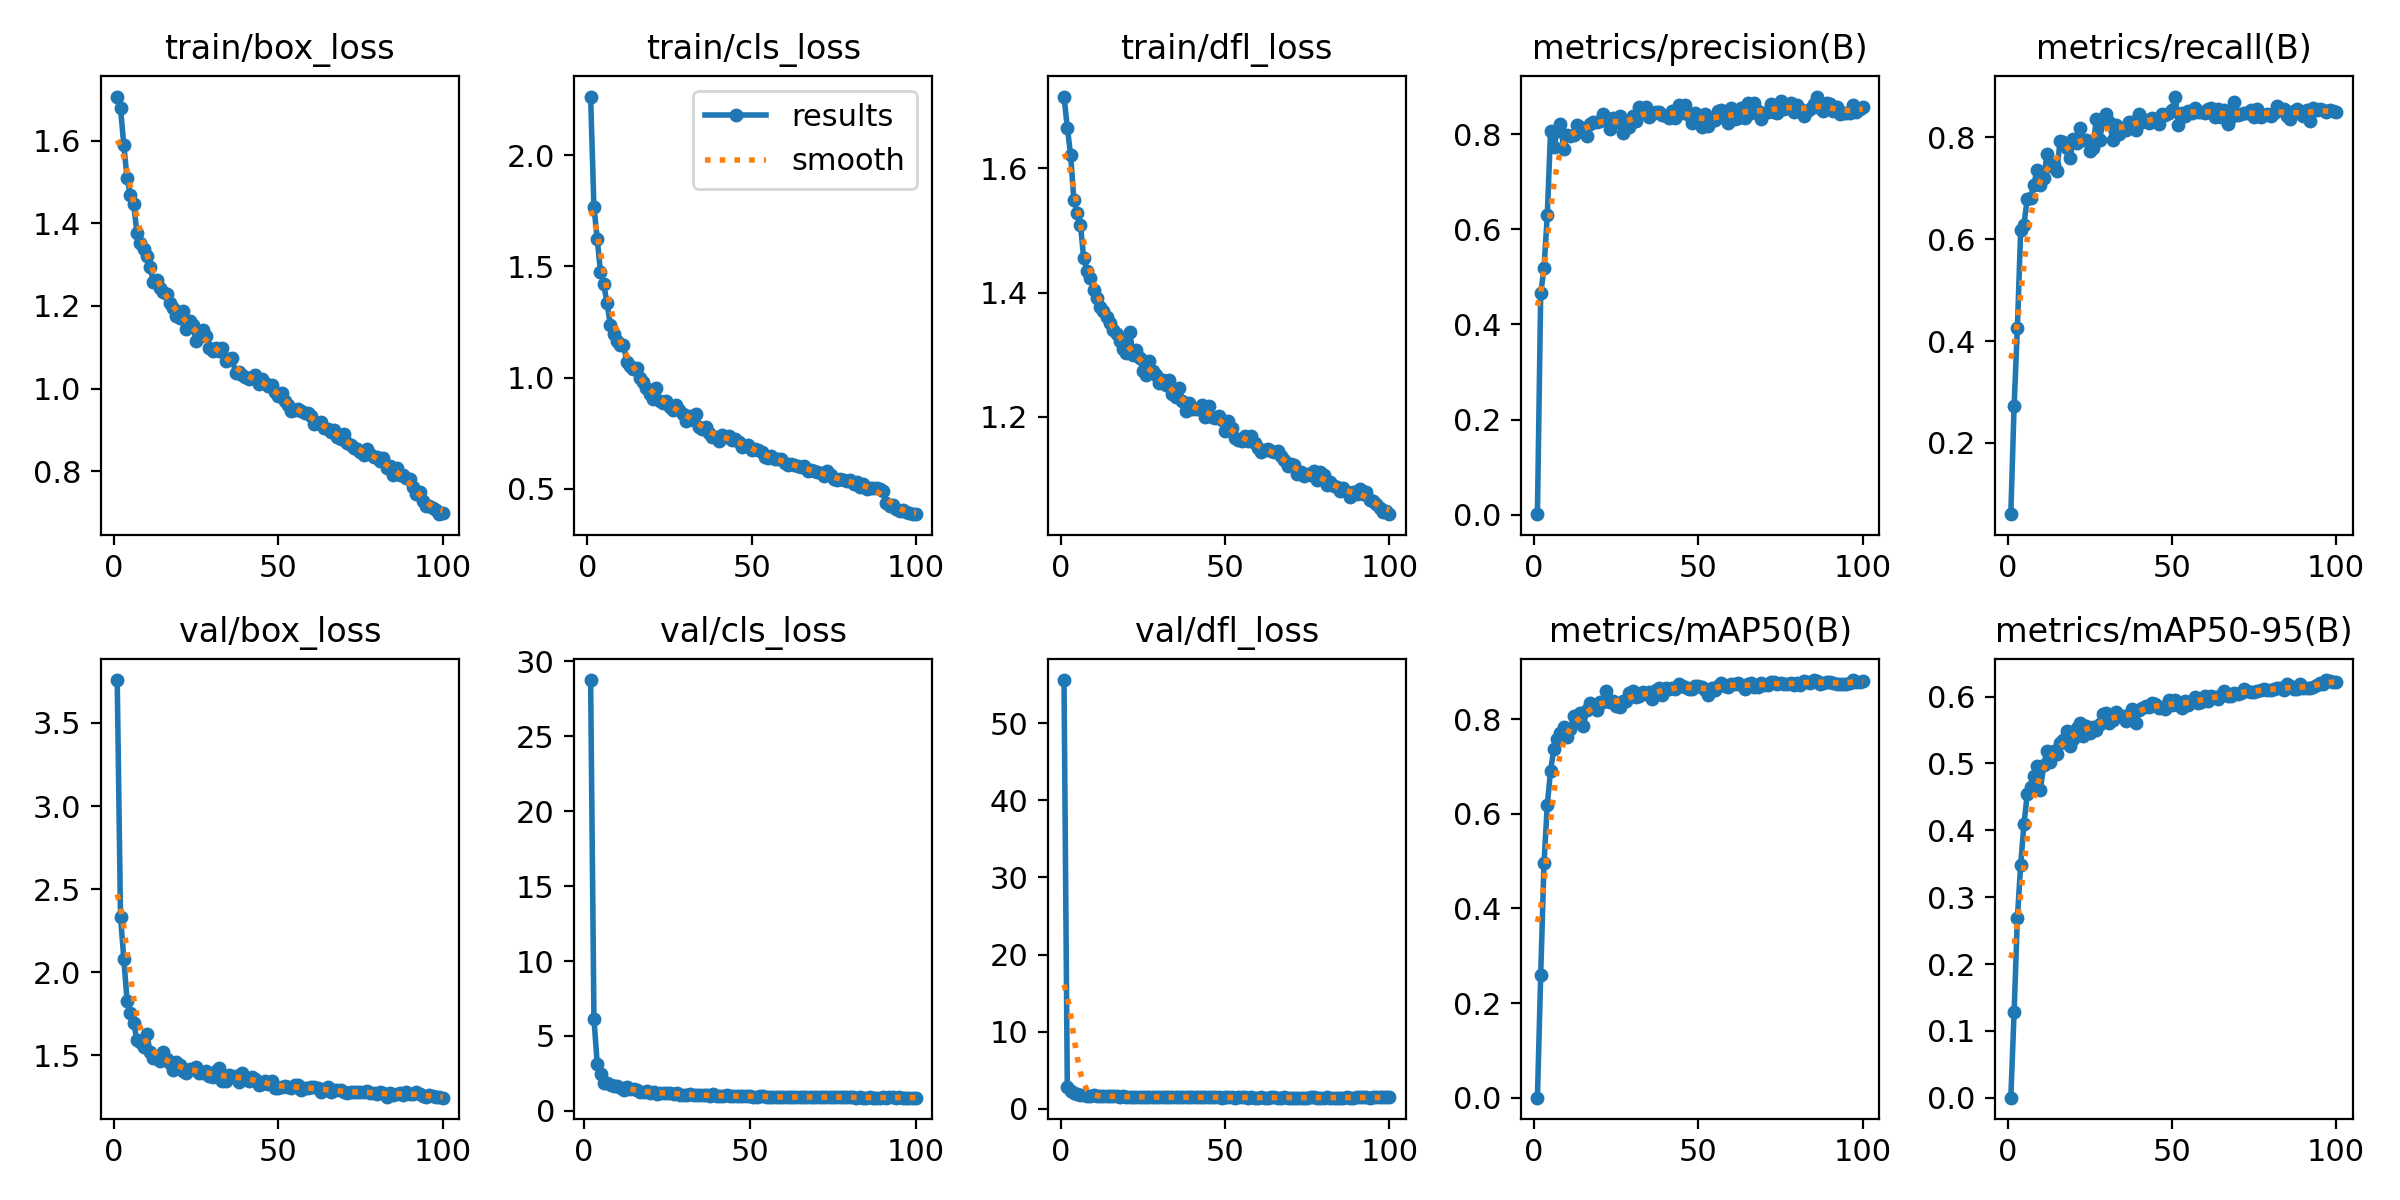


Confusion Matrix:


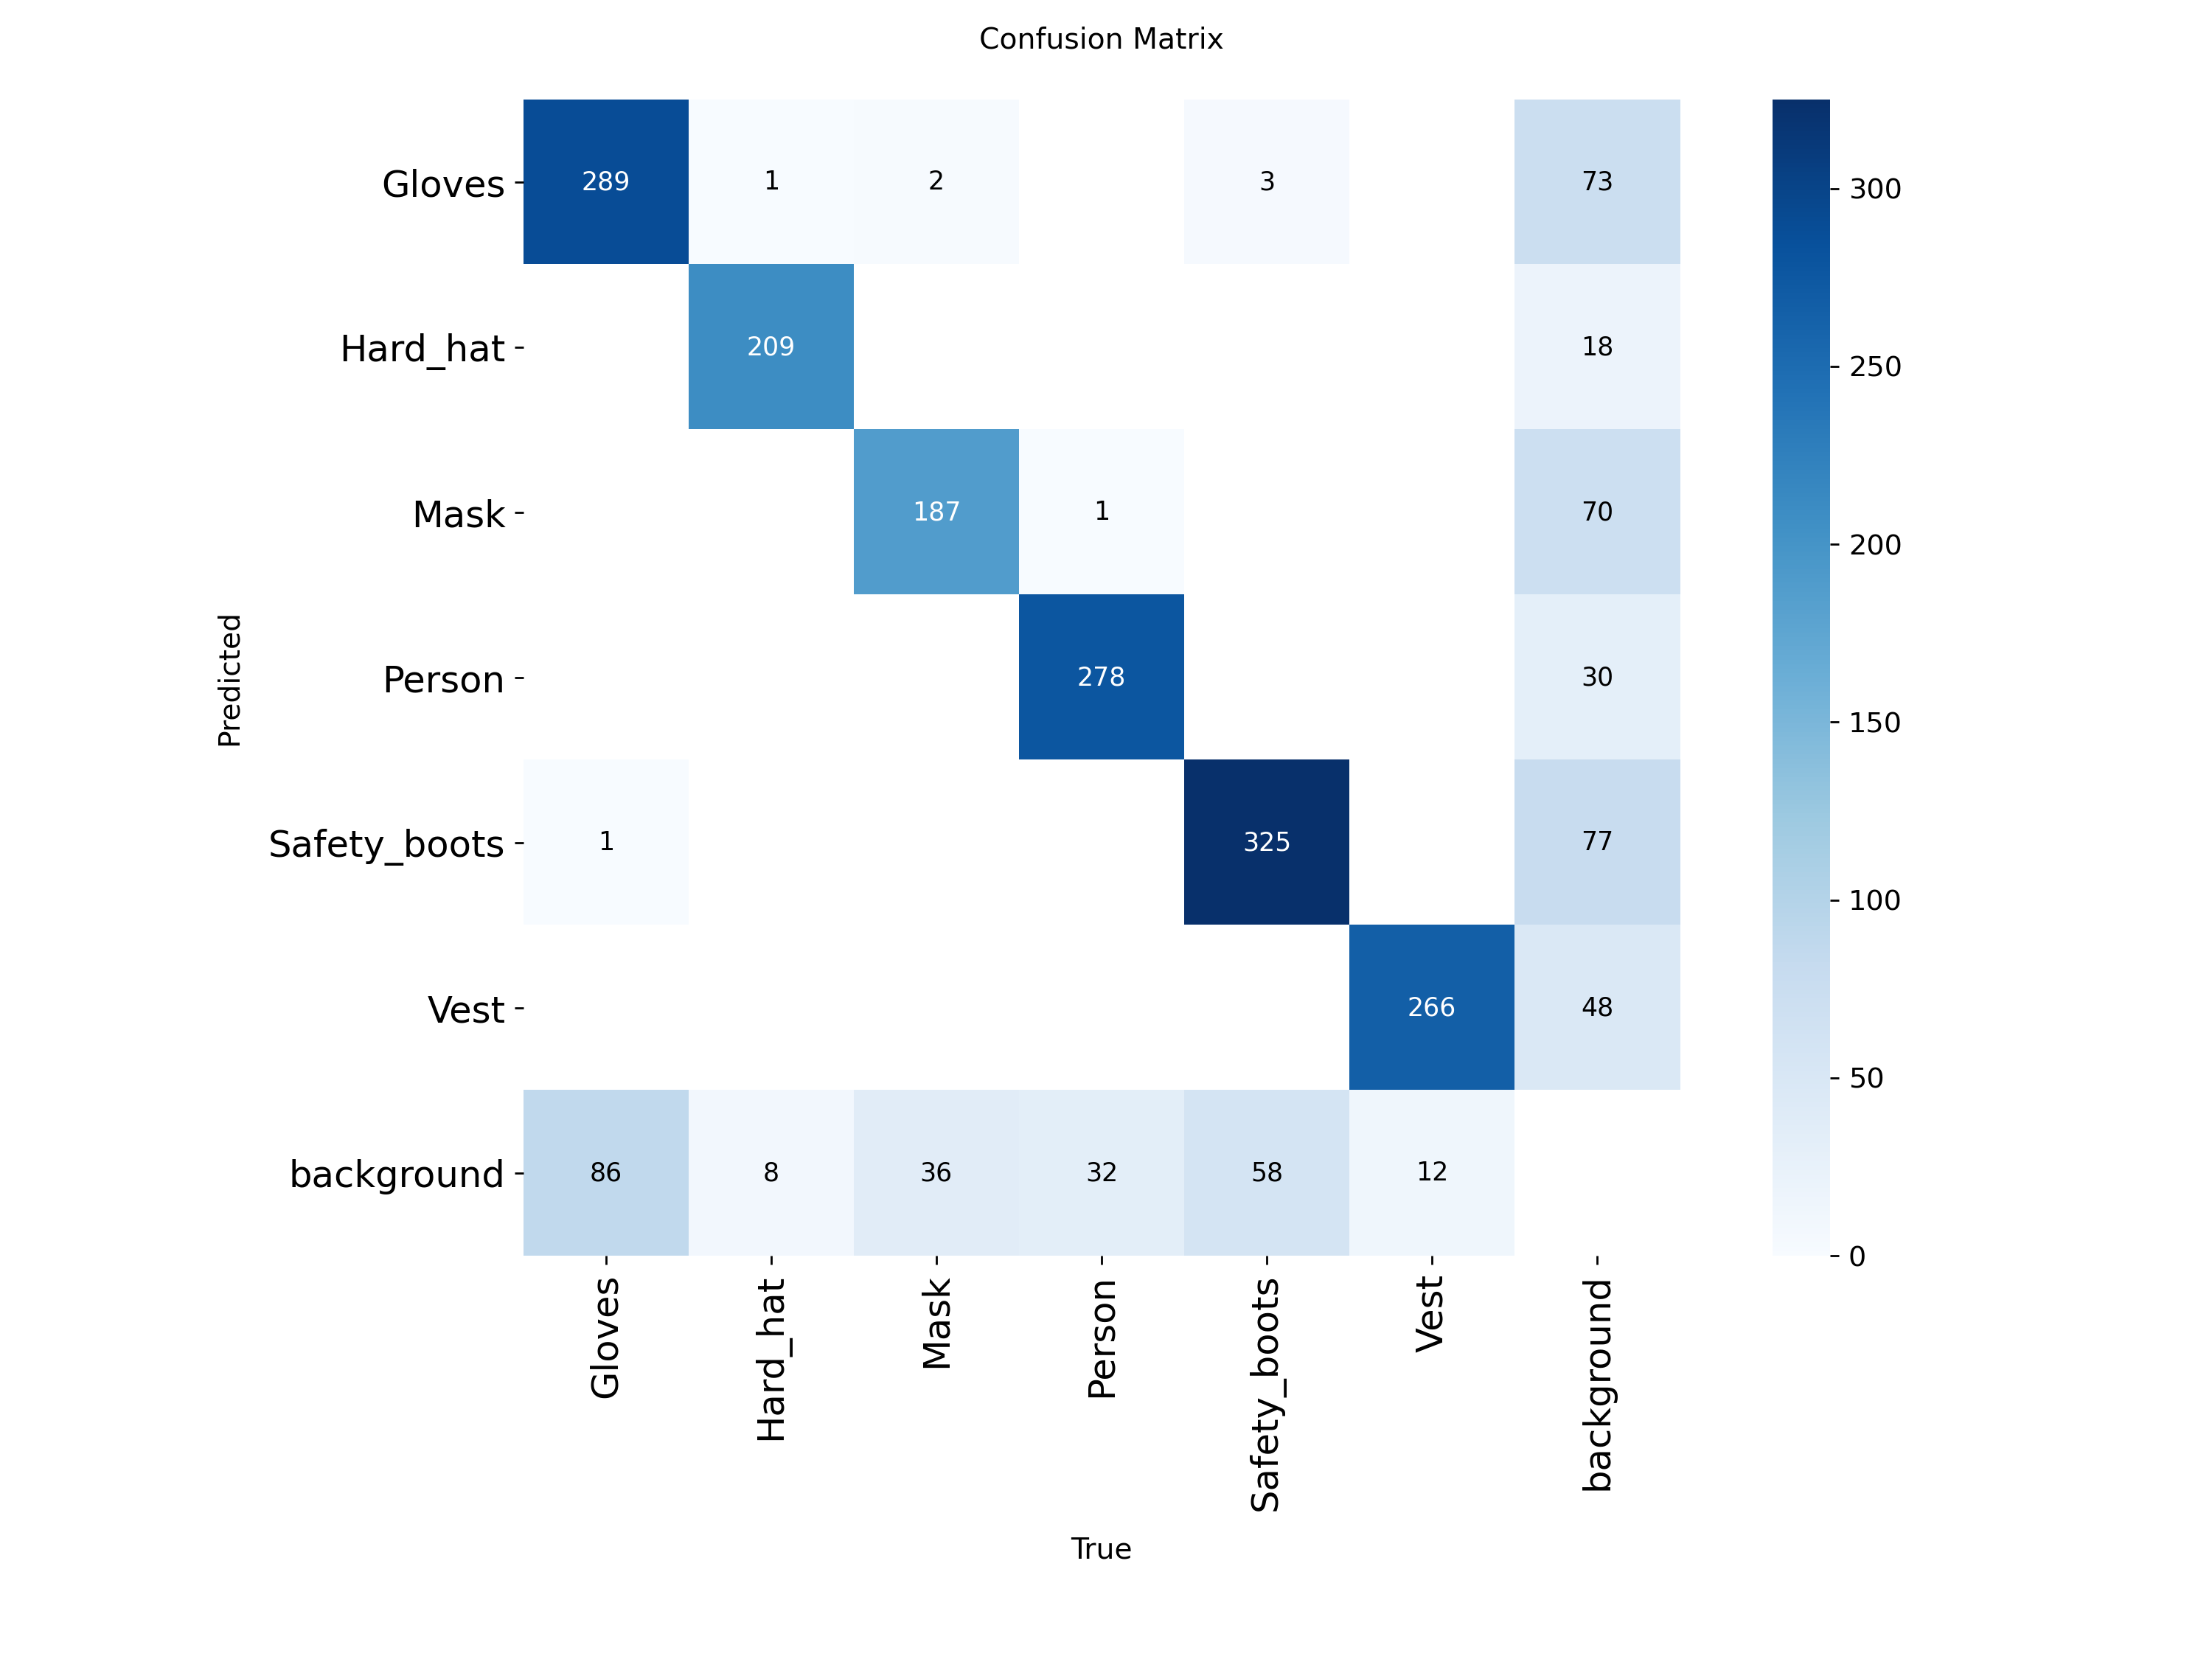


Normalized Confusion Matrix:


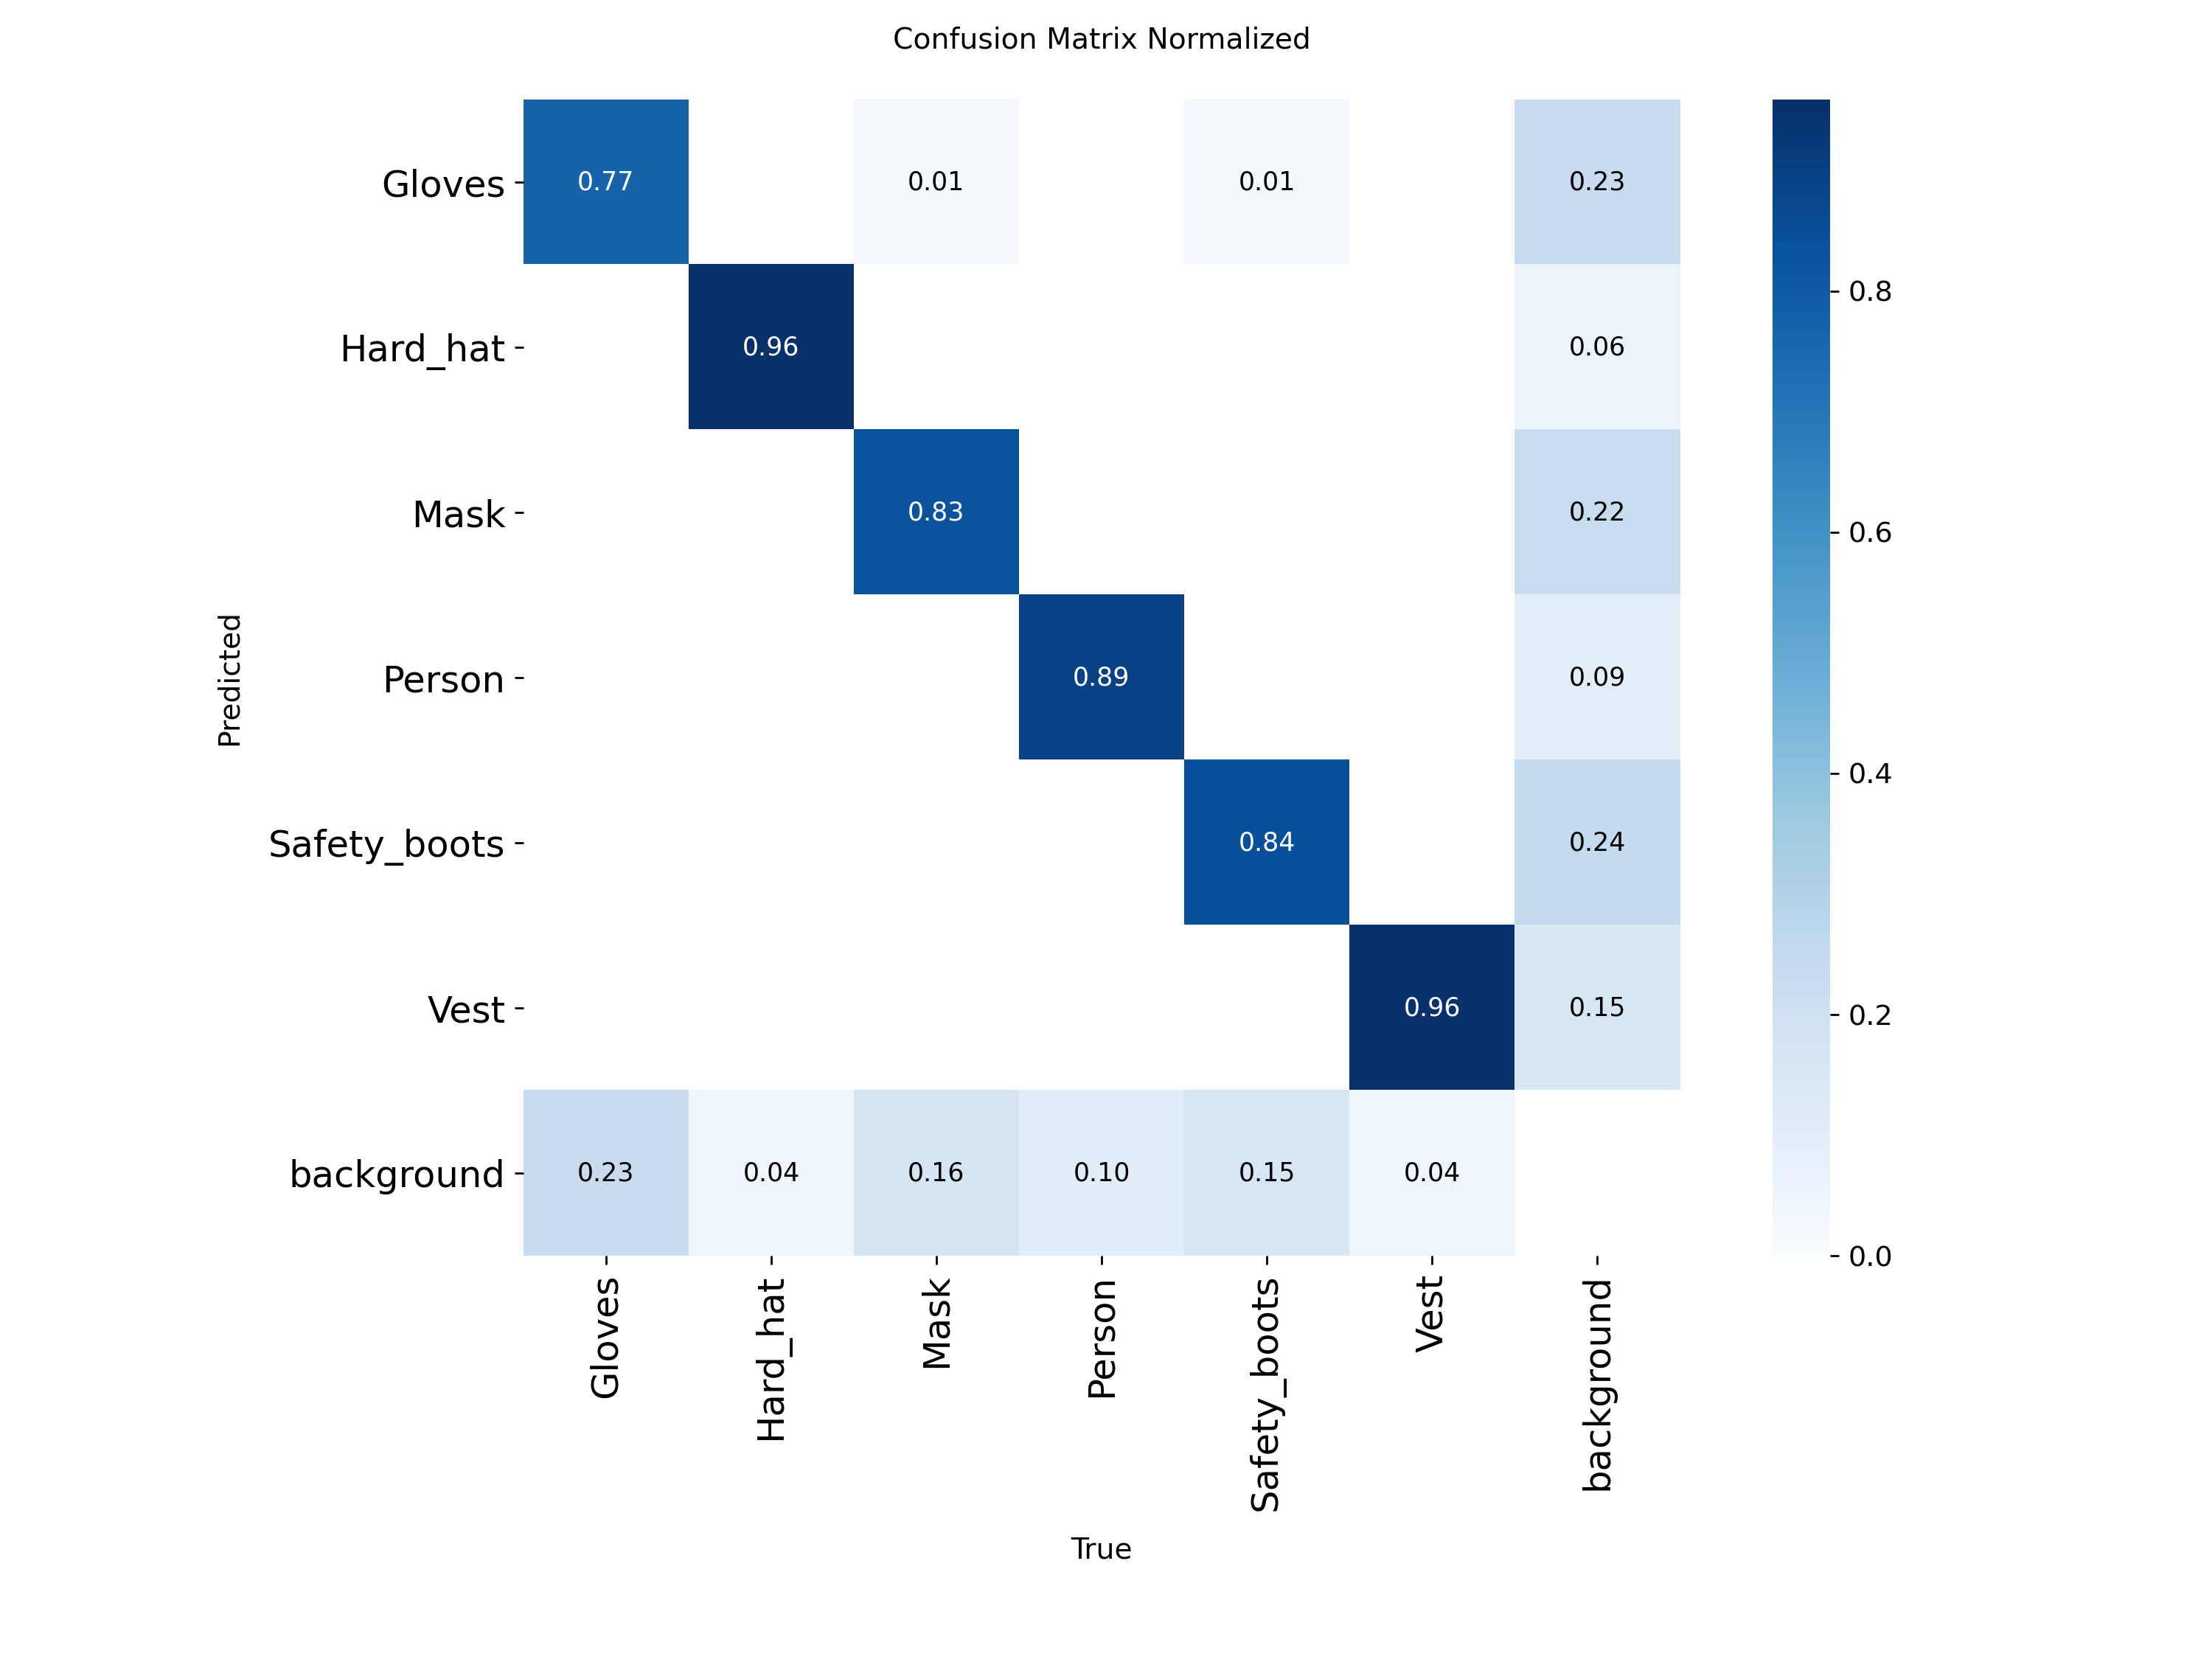


F1 Score Curve:


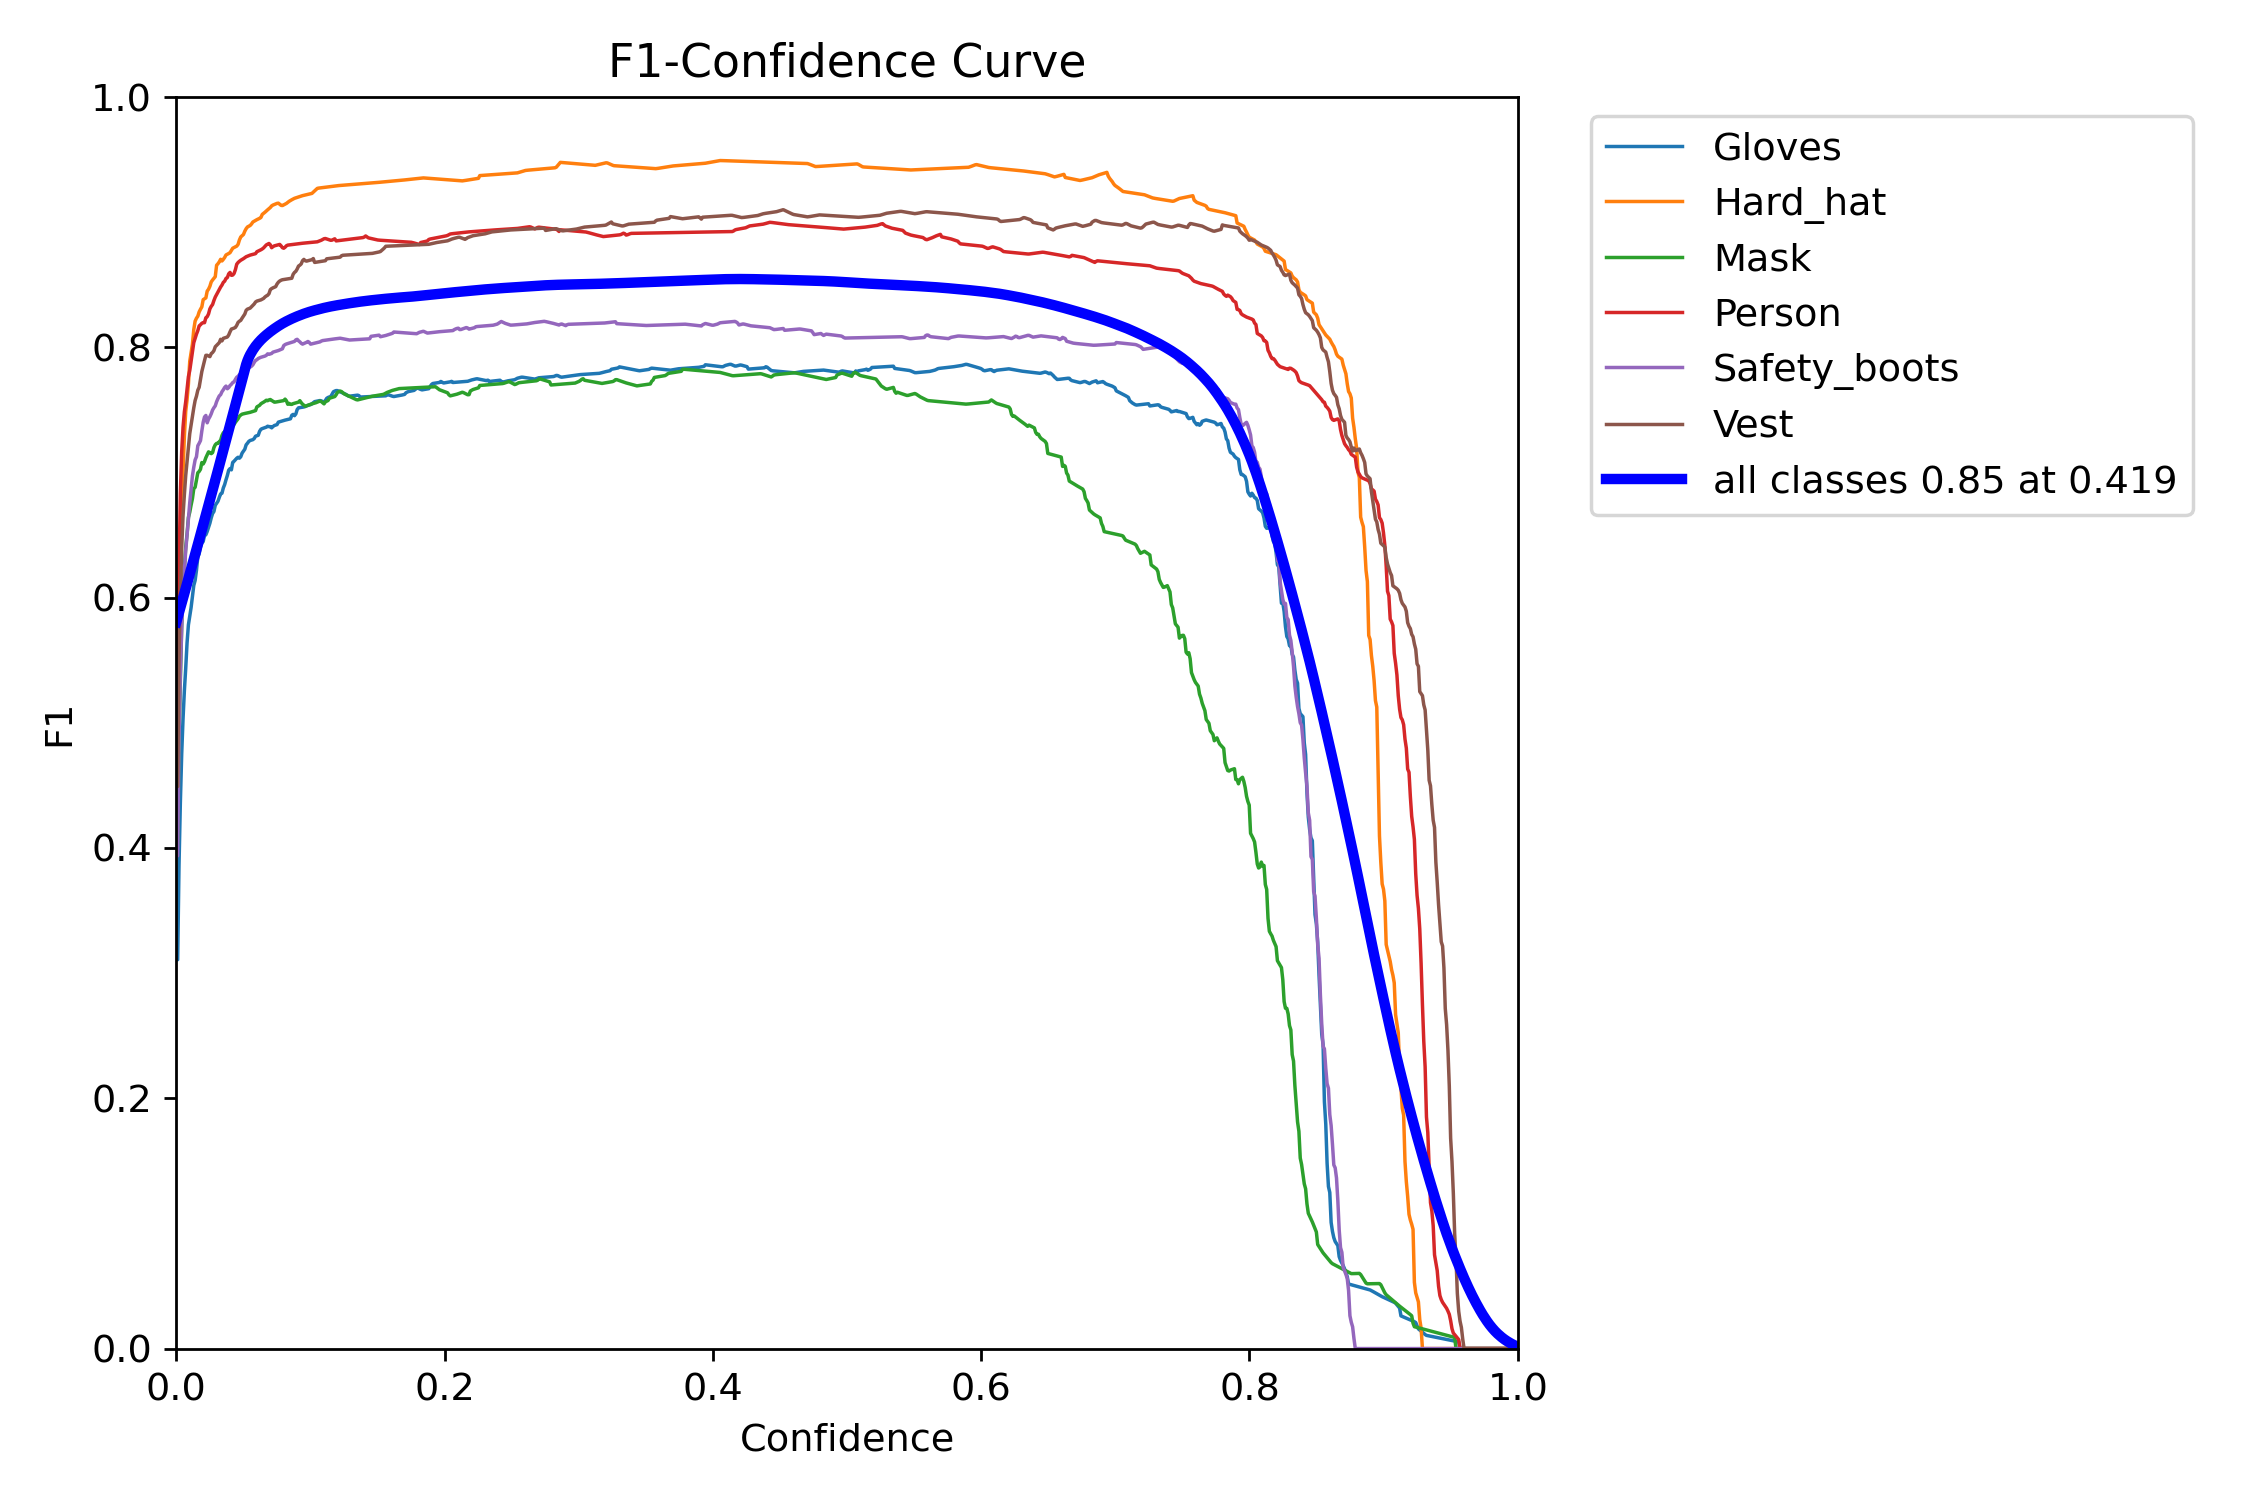


Precision-Recall Curve:


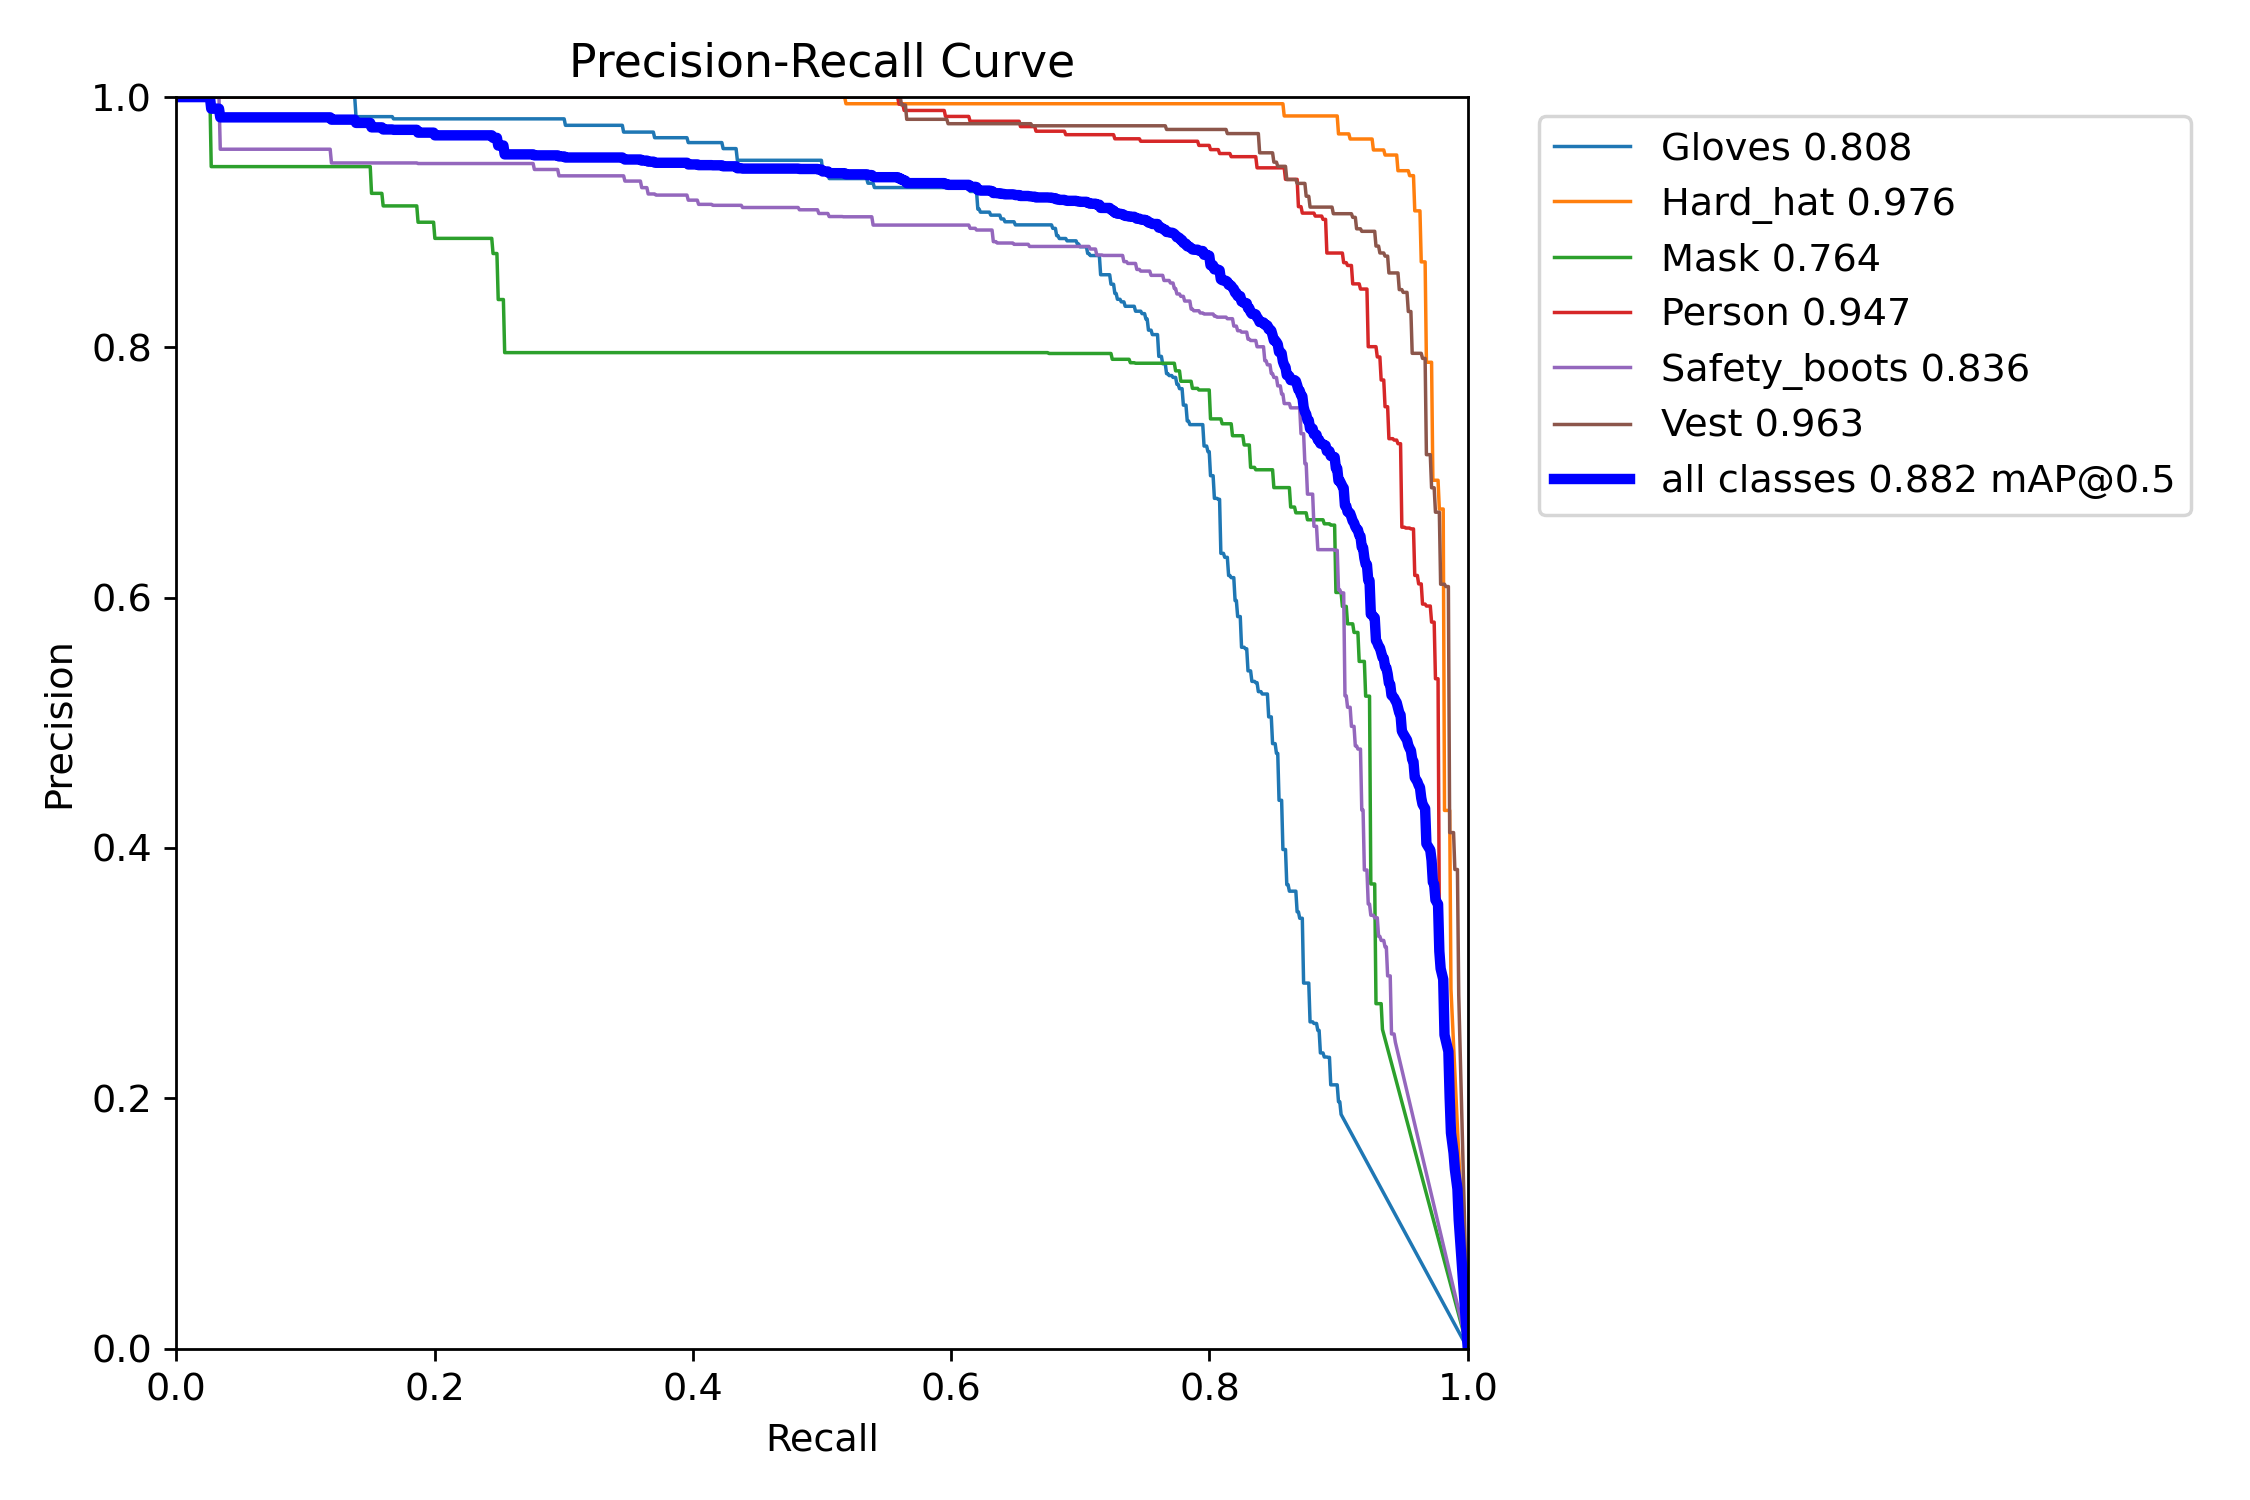

In [ ]:
# Display training curves
print(f"\nTraining Curves (Loss & Metrics over Epochs):")
results_img = f"{results_dir}/results.png"
if os.path.exists(results_img):
    display(IPImage(filename=results_img))
else:
    print("results.png not found")

# Display confusion matrix
print(f"\nConfusion Matrix:")
cm_img = f"{results_dir}/confusion_matrix.png"
if os.path.exists(cm_img):
    display(IPImage(filename=cm_img))
else:
    print("confusion_matrix.png not found")

# Display normalized confusion matrix
print(f"\nNormalized Confusion Matrix:")
cm_norm_img = f"{results_dir}/confusion_matrix_normalized.png"
if os.path.exists(cm_norm_img):
    display(IPImage(filename=cm_norm_img))
else:
    print("confusion_matrix_normalized.png not found")

# Display F1 curve
print(f"\nF1 Score Curve:")
f1_img = f"{results_dir}/BoxF1_curve.png"
if os.path.exists(f1_img):
    display(IPImage(filename=f1_img))
else:
    print("F1_curve.png not found")

# Display PR curve
print(f"\nPrecision-Recall Curve:")
pr_img = f"{results_dir}/BoxPR_curve.png"
if os.path.exists(pr_img):
    display(IPImage(filename=pr_img))
else:
    print("PR_curve.png not found")


## Load Best Model & Run Predictions

In [ ]:
# Load the best model
best_model_path = f"{PROJECT_NAME}/{EXPERIMENT_NAME}/weights/best.pt"
trained_model = YOLO(best_model_path)

trained_model.info()

# Test on validation images
val_results = trained_model.val(
    data=data_yaml_path,
    split='val',
    save_json=True,
    save_hybrid=True,
)

print(f"\nValidation Results:")
print(f"mAP50: {val_results.box.map50:.3f}")
print(f"mAP50-95: {val_results.box.map:.3f}")
print(f"Precision: {val_results.box.mp:.3f}")
print(f"Recall: {val_results.box.mr:.3f}")

Model summary: 169 layers, 25,859,794 parameters, 0 gradients, 79.1 GFLOPs
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1580.7±673.5 MB/s, size: 45.9 KB)
val: Scanning /content/PPE-DETECTION-14/valid/labels.cache... 425 images, 47 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 425/425 900.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 2.1it/s 12.7s
                   all        425       1794      0.863      0.849      0.882      0.625
                Gloves        213        376      0.829      0.746      0.808      0.484
              Hard_hat        187        218      0.954      0.944      0.976      0.795
                  Mask        198        225      0.765      0.7

## Visualize Predictions on Test Images

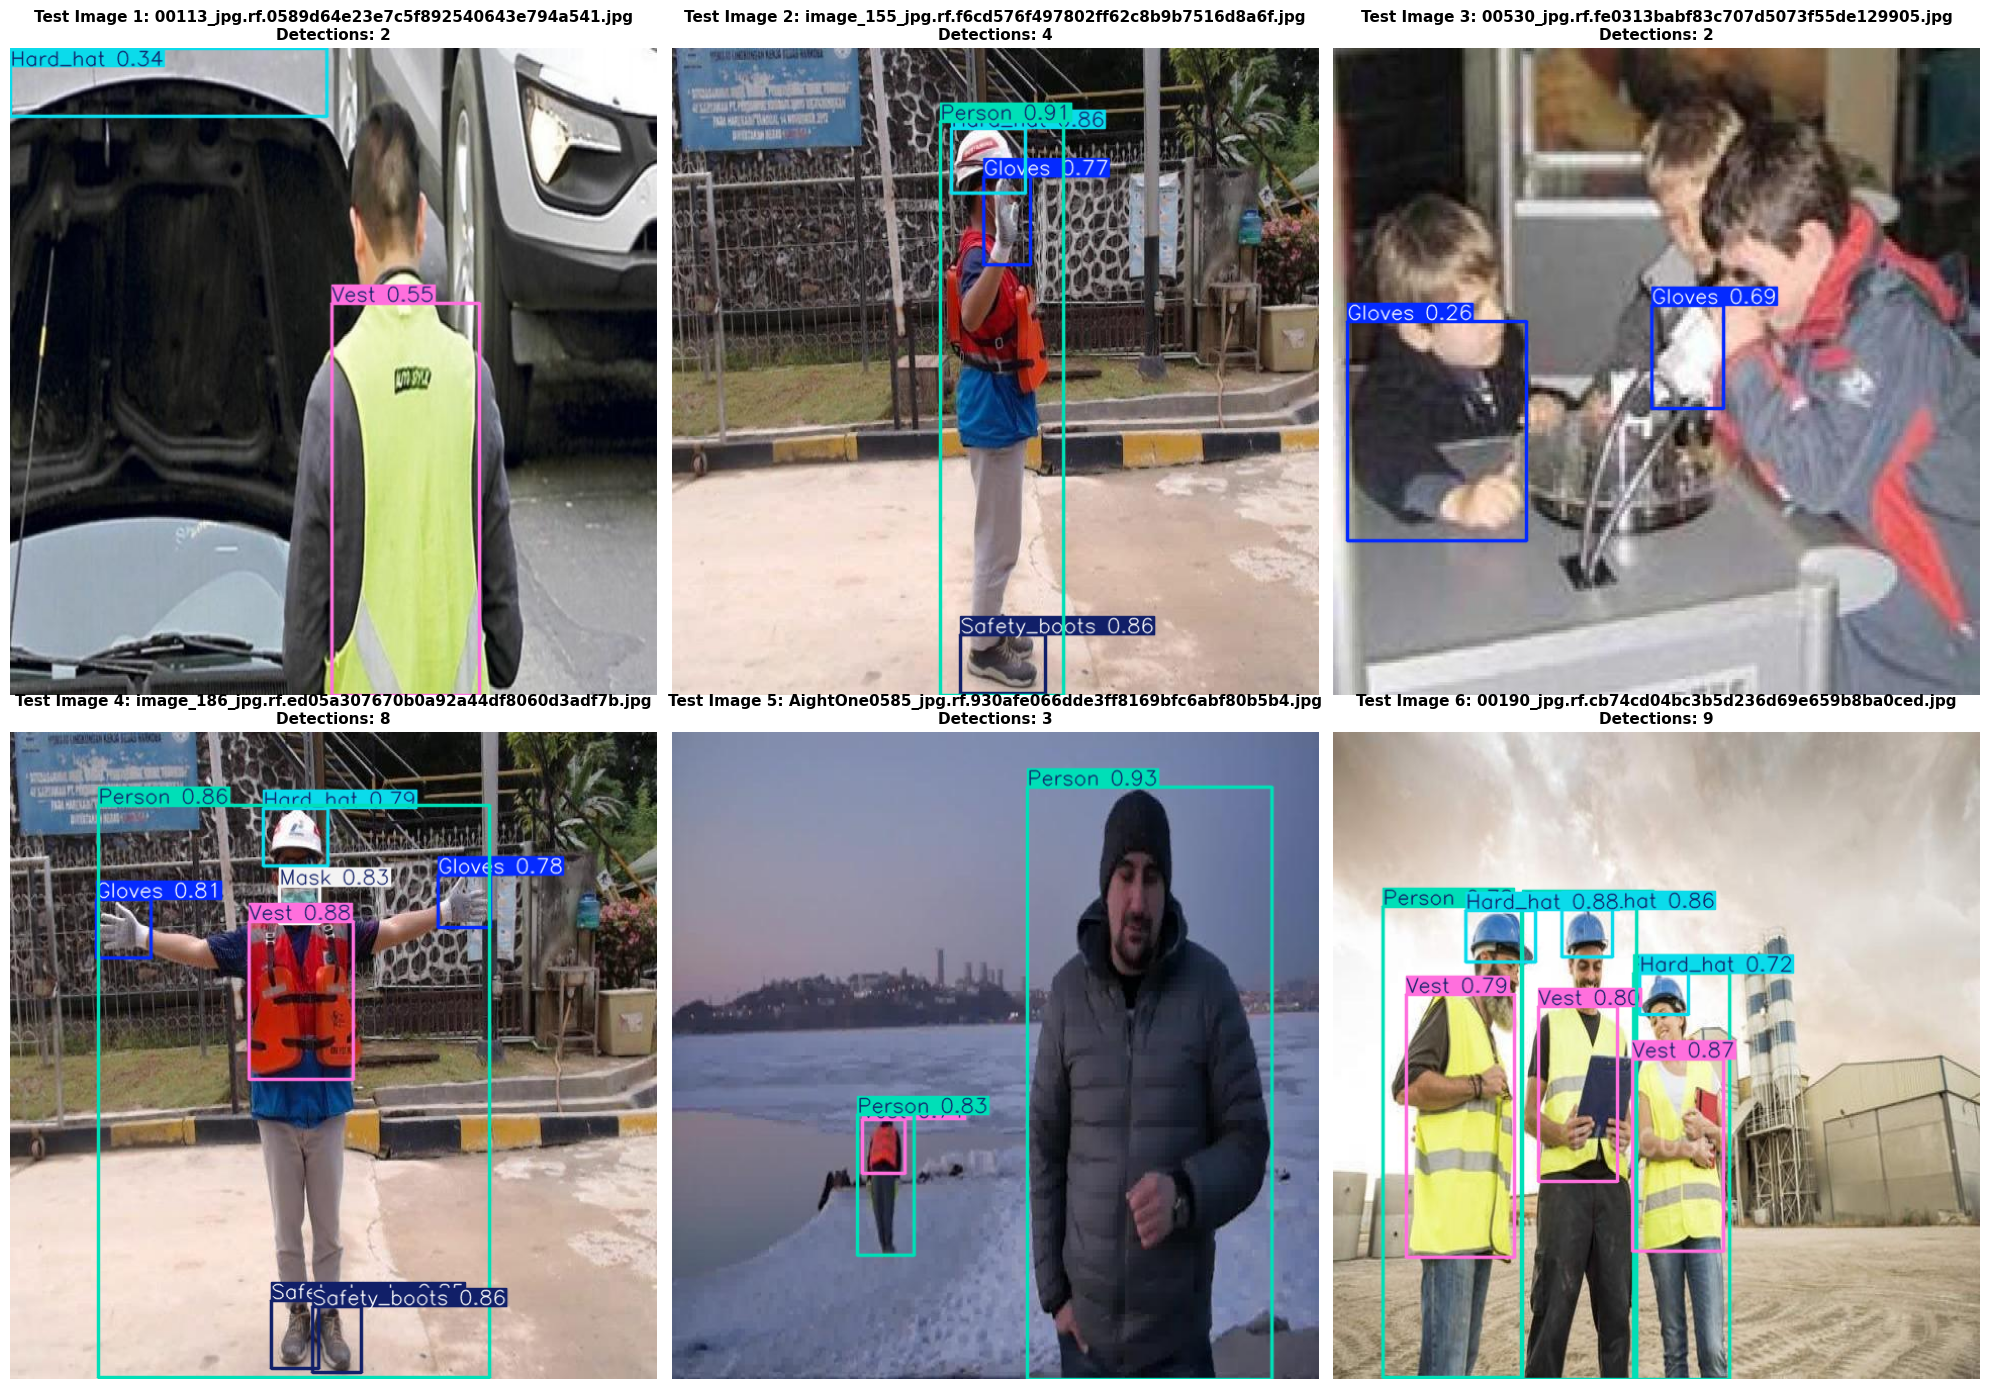


Detection Summary:

Image 1 (00113_jpg.rf.0589d64e23e7c5f892540643e794a541.jpg):
Total detections: 2
      - Vest: 1
      - Hard_hat: 1

Image 2 (image_155_jpg.rf.f6cd576f497802ff62c8b9b7516d8a6f.jpg):
Total detections: 4
      - Person: 1
      - Safety_boots: 1
      - Hard_hat: 1
      - Gloves: 1

Image 3 (00530_jpg.rf.fe0313babf83c707d5073f55de129905.jpg):
Total detections: 2
      - Gloves: 2

Image 4 (image_186_jpg.rf.ed05a307670b0a92a44df8060d3adf7b.jpg):
Total detections: 8
      - Vest: 1
      - Safety_boots: 2
      - Person: 1
      - Mask: 1
      - Gloves: 2
      - Hard_hat: 1

Image 5 (AightOne0585_jpg.rf.930afe066dde3ff8169bfc6abf80b5b4.jpg):
Total detections: 3
      - Person: 2
      - Vest: 1

Image 6 (00190_jpg.rf.cb74cd04bc3b5d236d69e659b8ba0ced.jpg):
Total detections: 9
      - Hard_hat: 3
      - Vest: 3
      - Person: 3


In [ ]:

# Get test images
test_images_dir = Path(f"{dataset.location}/test/images")
test_image_files = list(test_images_dir.glob('*.jpg')) + list(test_images_dir.glob('*.png'))

# Select random samples
num_test_samples = 6
test_samples = random.sample(test_image_files, min(num_test_samples, len(test_image_files)))

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, img_path in enumerate(test_samples):
    # Run prediction
    results = trained_model.predict(
        source=str(img_path),
        conf=0.25,  # Confidence threshold
        iou=0.45,   # NMS IoU threshold
        verbose=False
    )

    # Get annotated image
    result = results[0]
    annotated_img = result.plot()

    # Convert BGR to RGB
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Display
    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f"Test Image {idx+1}: {img_path.name}\n"
                       f"Detections: {len(result.boxes)}",
                       fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/ppe_detection_project/visualizations/test_predictions.png',
            dpi=150, bbox_inches='tight')
plt.show()

# Print detection summary
print(f"\nDetection Summary:")
for idx, img_path in enumerate(test_samples):
    results = trained_model.predict(source=str(img_path), conf=0.25, verbose=False)
    result = results[0]

    # Count detections by class
    class_counts = {}
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = data_config['names'][class_id]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    print(f"\nImage {idx+1} ({img_path.name}):")
    print(f"Total detections: {len(result.boxes)}")
    for class_name, count in class_counts.items():
        print(f"      - {class_name}: {count}")

## Demo for local run  


Run from here for the demonstration

1. Workers WITH both helmet + vest -> will get access
2. Workers missing helmet or vest -> will be denied
3. Workers WITHOUT helmet/vest -> will be denied

In [1]:
pip install ultralytics opencv-python matplotlib pyyaml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from datetime import datetime
from pathlib import Path
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import yaml
import tkinter as tk
from tkinter import filedialog

def select_demo_images():
    # Create root window (hidden)
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    
    # Open file dialog
    file_paths = filedialog.askopenfilenames(
        title='Select PPE Test Images',
        filetypes=[
            ('Image files', '*.jpg *.jpeg *.png *.bmp'),
            ('JPEG files', '*.jpg *.jpeg'),
            ('PNG files', '*.png'),
            ('All files', '*.*')
        ]
    )
    
    root.destroy()
    
    if not file_paths:
        print("No images selected!")
        return []
    
    # Convert to Path objects
    selected_images = [Path(f) for f in file_paths]
    
    print(f"\nSelected {len(selected_images)} image(s):")
    for img in selected_images:
        print(f"  - {img.name}")
    
    return selected_images

my_demo_images = select_demo_images()


Selected 2 image(s):
  - construction-worker-in-blue-helmet-and-orange-safety-vest-smiling-hands-on-hips-white-background-photo.jpg
  - istockphoto-1200677760-612x612.jpg


PPE GATE CONTROL SIMULATION

Processing 2 worker(s)...

────────────────────────────────────────────────────────────
WORKER #01
Time: 2026-01-11 01:01:03
────────────────────────────────────────────────────────────

DETECTION RESULTS:
Total items detected: 3
- Person: 92.3% confidence
- Vest: 89.1% confidence
- Hard_hat: 87.4% confidence

PPE COMPLIANCE CHECK:
Required: Helmet + Vest
Helmet: [✓] DETECTED
Vest:   [✓] DETECTED

GATE CONTROL DECISION:
>>>> ACCESS GRANTED <<<<
Gate OPENS - Worker may enter site

────────────────────────────────────────────────────────────
DISPLAYING ANNOTATED IMAGE:
────────────────────────────────────────────────────────────


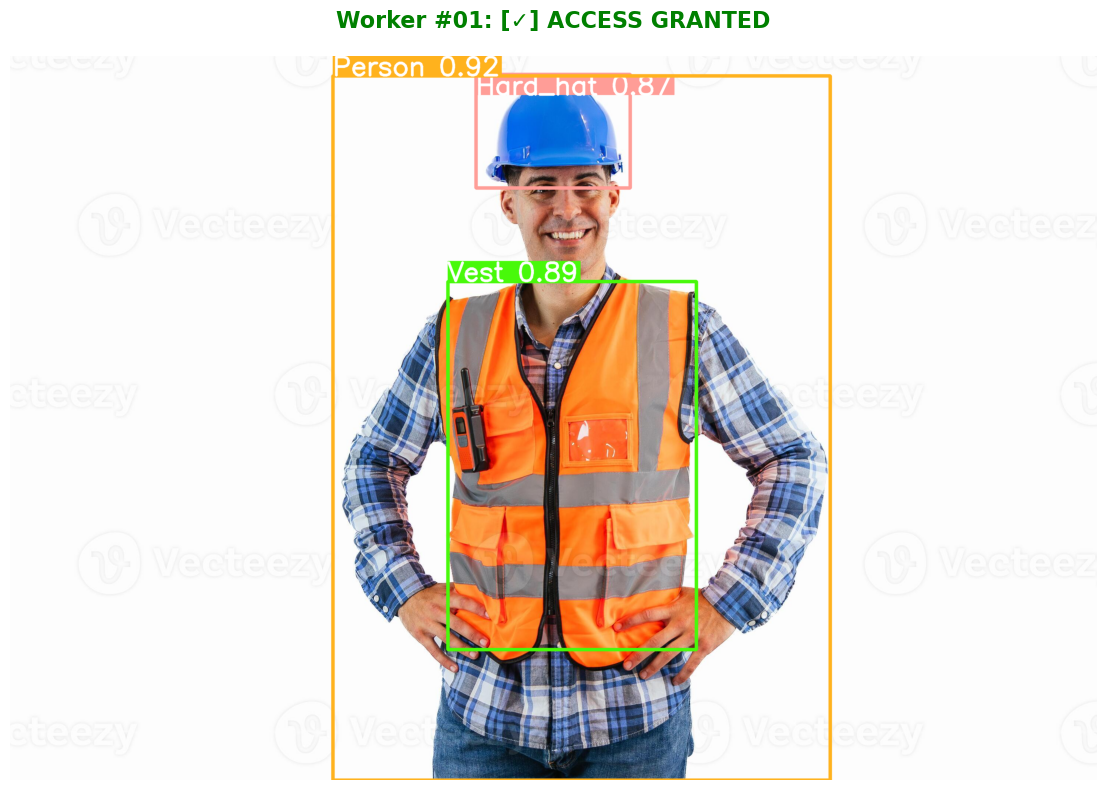


────────────────────────────────────────────────────────────
WORKER #02
Time: 2026-01-11 01:01:06
────────────────────────────────────────────────────────────

DETECTION RESULTS:
Total items detected: 1
- Person: 83.1% confidence

PPE COMPLIANCE CHECK:
Required: Helmet + Vest
Helmet: [×] MISSING
Vest:   [×] MISSING

GATE CONTROL DECISION:
>>>> ACCESS DENIED <<<<
Gate REMAINS CLOSED
  Missing: Helmet, Vest

────────────────────────────────────────────────────────────
DISPLAYING ANNOTATED IMAGE:
────────────────────────────────────────────────────────────


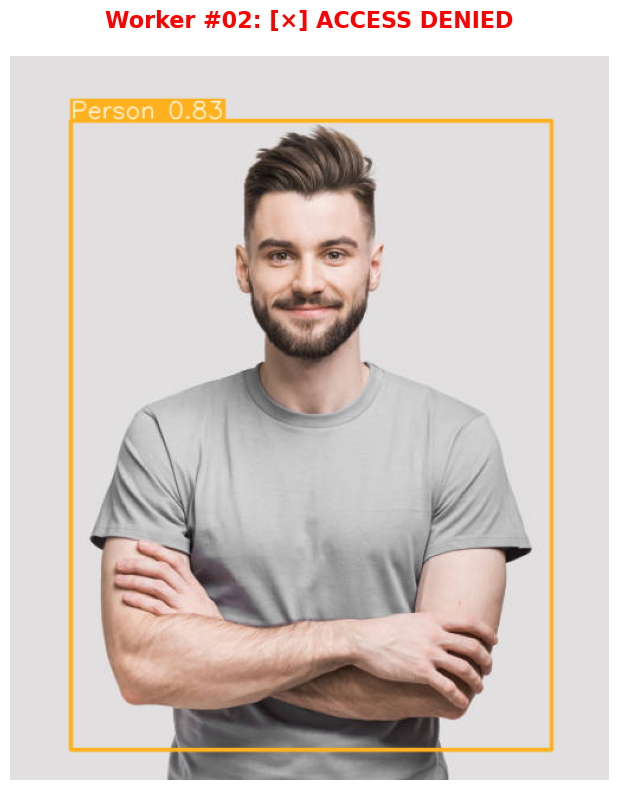

In [4]:
#Gate control Simulation
#Check local training results
local_model = Path(r'ppe_detection_project\ppe_helmet_vest_detection_v1\weights\best.pt')

if local_model.exists():
  trained_model = YOLO(str(local_model))

  # Get data config
  yaml_path = Path(r'PPE-DETECTION-14\data.yaml')

  if yaml_path.exists():
      with open(yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
  else:
        # Hardcode
      data_config = {
          'names': ['Gloves', 'Hard_hat', 'Mask', 'Person', 'Safety_boots', 'Vest'],
          'nc': 6
        }

print("PPE GATE CONTROL SIMULATION")
print("="*60)

# Check if images were selected
if len(my_demo_images) == 0:
    print("ERROR: No images selected!")
    print("Please run again and select images.")
    exit()

print(f"\nProcessing {len(my_demo_images)} worker(s)...")

# Process each image
for idx, img_path in enumerate(my_demo_images, 1):
    print(f"\n{'─'*60}")
    print(f"WORKER #{idx:02d}")
    print(f"Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"{'─'*60}")

    # Run detection
    results = trained_model.predict(source=str(img_path), conf=0.30, verbose=False)
    result = results[0]

    # Analyze detections
    detected_items = []
    helmet_found = False
    vest_found = False

    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = data_config['names'][class_id]
        confidence = float(box.conf[0])

        detected_items.append({
            'name': class_name,
            'confidence': confidence
        })

        if class_name == 'Hard_hat':
            helmet_found = True
        if class_name == 'Vest':
            vest_found = True

    # Display detection results
    print(f"\nDETECTION RESULTS:")
    print(f"Total items detected: {len(detected_items)}")

    if len(detected_items) == 0:
        print(f"(No PPE or person detected)")
    else:
        for item in detected_items:
            print(f"- {item['name']}: {item['confidence']*100:.1f}% confidence")

    # Check PPE compliance
    print(f"\nPPE COMPLIANCE CHECK:")
    print(f"Required: Helmet + Vest")
    print(f"Helmet: {'[✓] DETECTED' if helmet_found else '[×] MISSING'}")
    print(f"Vest:   {'[✓] DETECTED' if vest_found else '[×] MISSING'}")

    # Gate decision
    is_compliant = helmet_found and vest_found

    print(f"\nGATE CONTROL DECISION:")
    if is_compliant:
        print(f">>>> ACCESS GRANTED <<<<")
        print(f"Gate OPENS - Worker may enter site")
    else:
        print(f">>>> ACCESS DENIED <<<<")
        print(f"Gate REMAINS CLOSED")
        missing = []
        if not helmet_found: missing.append("Helmet")
        if not vest_found: missing.append("Vest")
        print(f"  Missing: {', '.join(missing)}")

    # Display annotated image
    print(f"\n{'─'*60}")
    print(f"DISPLAYING ANNOTATED IMAGE:")
    print(f"{'─'*60}")

    # Get annotated image
    annotated_img = result.plot()

    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')

    # Add title based on status
    if is_compliant:
        title = f"Worker #{idx:02d}: [✓] ACCESS GRANTED"
        title_color = 'green'
    else:
        title = f"Worker #{idx:02d}: [×] ACCESS DENIED"
        title_color = 'red'

    plt.title(title, fontsize=16, fontweight='bold', color=title_color, pad=20)
    plt.tight_layout()
    plt.show()